# Lip Reading Project

## Dependencies

In [1]:
!pip install opencv-python matplotlip imageio gdown tensorFlow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Data Loading

In [4]:
import gdown

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=2cea6292-1b49-4c94-8297-2f4f7ec9a7e1
To: /Users/tadiparthia/Desktop/Deep Learning Models/LipReading/data.zip
100%|██████████| 423M/423M [00:15<00:00, 27.2MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary is: {char_to_num.get_vocabulary()} ", f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']  (size =40)


In [7]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

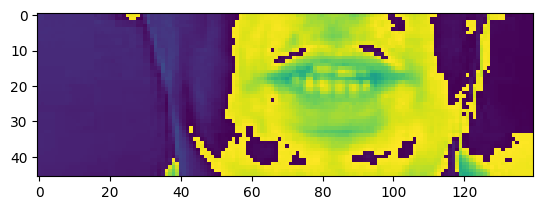

In [8]:
test_path = './data/s1/bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[40])

In [9]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [10]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [11]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# from typing import Tuple
# def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
#       result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
#       return result

## Data Pipeline

In [12]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [13]:
len(test)
frames, alignments = data.as_numpy_iterator().next()
len(frames)
sample = data.as_numpy_iterator()
val = sample.next()
val[0].shape

(2, 75, 46, 140, 1)

In [14]:
float_array = val[0][0]
frames = [frame.squeeze() for frame in float_array]
rescaled_frames = [(frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255 for frame in frames]
rescaled_frames_uint8 = [frame.astype(np.uint8) for frame in rescaled_frames]

imageio.mimsave('./animation.gif', rescaled_frames_uint8, fps=10)

In [15]:
# # Assuming `val[0][0]` is your image data
# # Normalize the data to 0-255 range if it's not already
# frames = val[0][0].astype(np.float32)
# frames -= frames.min()  # Normalize to 0
# frames /= frames.max()  # Normalize to 1
# frames *= 255.0         # Scale to 0-255
# frames = frames.astype(np.uint8)  # Convert to uint8

# # Remove the last dimension if it's 1
# frames = np.squeeze(frames)

# # Save the animation
# imageio.mimsave('./animation.gif', frames, fps=10)

In [16]:
# sample = data.as_numpy_iterator()
# val = sample.next()
# fv = (val[0][1].astype(np.uint8) * 255).squeeze()
# imageio.mimsave('./animation.gif', fv, duration=100)

In [17]:
# # Check the shape and data type of frames array
# frames_array = val[0][1]
# print("Frames array shape:", frames_array.shape)
# print("Frames array data type:", frames_array.dtype)

# # Convert frames to uint8 and scale to [0, 255]
# frames_array_uint8 = np.uint8(frames_array * 255)

# # Squeeze the frames array to remove the singleton dimension
# frames_array_uint8_squeezed = np.squeeze(frames_array_uint8)

# # Save frames as animated GIF
# imageio.mimsave('./animation.gif', frames_array_uint8_squeezed, fps=10)

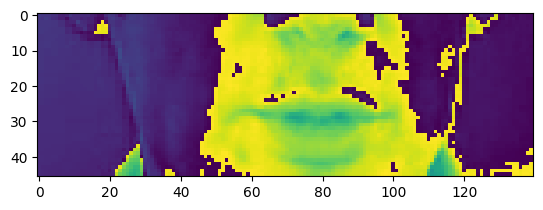

In [18]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [19]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by c four now'>

## Design the Deep Neural Network

In [20]:
from keras.models import Sequential
from keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, Input
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [21]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [22]:
model = Sequential()
model.add(Input(shape=(75, 46, 140, 1)))
model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer=initializers.Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer=initializers.Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
5*17*75

6375

In [25]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [26]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk6666666666'>

In [27]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk6666666666'>

In [28]:
model.input_shape

(None, 75, 46, 140, 1)

In [29]:
model.output_shape

(None, 75, 41)

## Training

In [30]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [31]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [32]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [36]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [37]:
schedule_callback = LearningRateScheduler(scheduler)

In [38]:
example_callback = ProduceExample(data)

In [40]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback], verbose=1)

Epoch 1/100


2024-03-15 18:59:40.103232: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-03-15 18:59:40.103249: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-03-15 18:59:40.103255: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-03-15 18:59:40.103266: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-03-15 18:59:40.103273: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-03-15 18:59:40.103278: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed a

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_39 defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/6t/dsbm3zg568j74d6h0bgjsb800000gq/T/ipykernel_54821/982789225.py", line 1, in <module>

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/models/sequential.py", line 203, in call

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py", line 188, in call

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py", line 572, in call

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in call

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in <listcomp>

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/time_distributed.py", line 102, in step_function

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/ops/numpy.py", line 4499, in reshape

  File "/Users/tadiparthia/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/numpy.py", line 1378, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_39}}]] [Op:__inference_one_step_on_iterator_31106]

## Predictions

In [41]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=e23630af-0045-419f-a709-73dbc6f16e63
To: /Users/tadiparthia/Desktop/Deep Learning Models/LipReading/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:04<00:00, 21.9MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [42]:
model.load_weights('models/checkpoint')

ValueError: File format not supported: filepath=models/checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.